In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2025 conference paper
# Load datasets

In [2]:
datapath = "simulationVictor/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,output
0,0.008314,0.112446,0.019537,32
1,0.030597,0.509708,0.538982,20
2,0.035434,0.536123,0.622389,9
3,0.085320,0.519522,0.770560,0
4,0.093312,0.121861,0.860966,0
...,...,...,...,...
3995,0.000478,0.546819,0.683051,307
3996,0.043992,0.370331,0.283118,0
3997,0.021458,0.215368,0.217972,21
3998,0.015237,0.992937,0.585146,9


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [4]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau']].values
Yts = dbtest[['output']].values
Yts[Yts>1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau']].values
Ycal = dbcal[['output']].values
Ycal[Ycal>1] = -1
Ycal[Ycal==0] = 1

In [5]:
print(dbtrain.info())
print(Xtr.dtype)
Ytr.dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SafetyMargin  4000 non-null   float64
 1   Eta           4000 non-null   float64
 2   Tau           4000 non-null   float64
 3   output        4000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 125.1 KB
None
float64


dtype('int64')

# SVM parameters setting

In [6]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.5 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [7]:
epsilon = 0.1

## 1) Classic SVM

In [8]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr,Ytr)
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 80.29359698295593 seconds


In [9]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([ 5.00004301e-01,  5.00003649e-01,  5.00002920e-01, ...,
         5.00005693e-01,  5.00001215e-01, -1.72921545e-06]),
 'b': array([-0.07496615]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

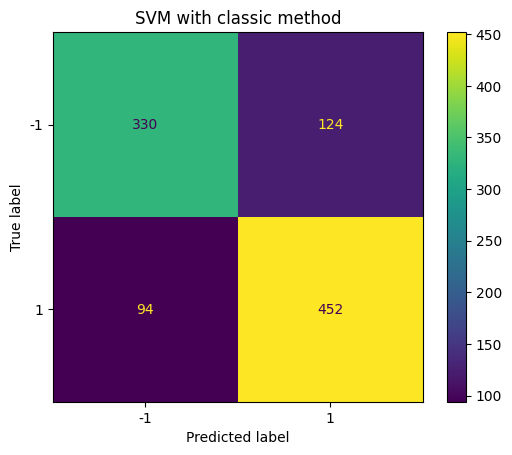

ACC = 0.782, F1 = 0.8057040998217468, PPV = 0.7847222222222222, NPV = 0.7783018867924528, TPR = 0.8278388278388278, TNR = 0.7268722466960352, FPR = 0.27312775330396477, FNR = 0.17216117216117216

TP = 452, FP = 124, TN = 330, FN = 94


In [10]:
metricsClassic = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")


In [11]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictor/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [12]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([ 5.00004301e-01,  5.00003649e-01,  5.00002920e-01, ...,
         5.00005693e-01,  5.00001215e-01, -1.72921545e-06]),
 'b': array([-0.07496615]),
 'b_eps': 0.47854911531010635,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

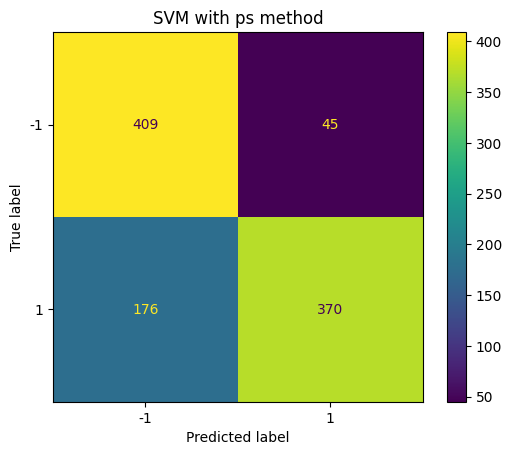

ACC = 0.779, F1 = 0.7700312174817898, PPV = 0.891566265060241, NPV = 0.6991452991452991, TPR = 0.6776556776556777, TNR = 0.9008810572687225, FPR = 0.09911894273127753, FNR = 0.32234432234432236

TP = 370, FP = 45, TN = 409, FN = 176


In [13]:
metricsPSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [14]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictor/PS_SVM_safe.sav']

In [15]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [16]:
model = model.FPcontrol(Xcal, Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([ 5.00004301e-01,  5.00003649e-01,  5.00002920e-01, ...,
         5.00005693e-01,  5.00001215e-01, -1.72921545e-06]),
 'b': array([-0.07496615]),
 'b_eps': 0.440985514276655,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

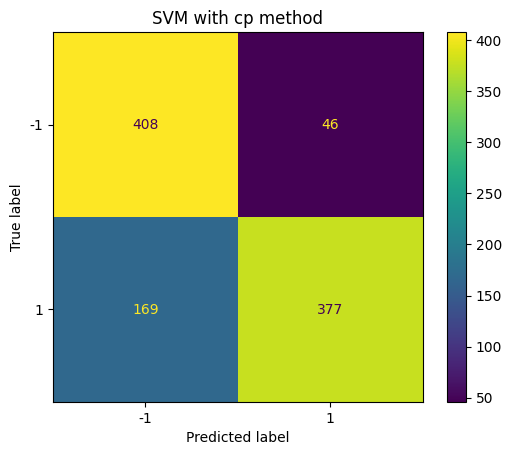

ACC = 0.785, F1 = 0.7781217750257998, PPV = 0.8912529550827423, NPV = 0.707105719237435, TPR = 0.6904761904761905, TNR = 0.8986784140969163, FPR = 0.1013215859030837, FNR = 0.30952380952380953

TP = 377, FP = 46, TN = 408, FN = 169


In [17]:
metricsCSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [18]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictor/CP_SVM_safe.sav']

In [19]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)